# N-body simulation

This simulation accounts for gravitational interaction between N massive bodies, along with the option to consider inelastic collisions between the masses.  Additionally, a function for calculating the energy at each time step of the simulation is included.  The simulation data may be exported as csv files and then animated using the accompanying notebook.

Contents:

[Main simulation loop](#sim_loop)

[Calculation of energy](#energy_function)

[Collision checking](#collision_function)

[Run & Export](#run)

[Energy plotting](#energy_plots)

## Simulation Loop <a id='sim_loop'></a>

In [1]:
# import packages

import numpy as np
import math
from scipy.optimize import bisect
import matplotlib.pyplot as plt

# initial conditions format is [parameter planet 1, parameter planet 2, ...] where
# parameter planet = [position in x (s_x), s_y, s_z, v_x, v_y, v_z, mass, radius]
# input in arrays, output in arrays
# other inputs are dt (size of the time step), t_0 (initial time), t_f (final time) 
# optional parameters are the value of the gravitational constant G and do_collisions, which is automatically set to false
# when do_collisions is set to true, the simulation will do inelastic collisions when two planets are overlapping
# the function uses leapfrog integration to determine the positions and velocities of the bodies after each timestep
# the function starts at the initial conditions and t_0 and integrates up to when t_f is passed
# the function also computes the energy of the system based on the initial conditions and after every time step
# the outputs are arrays of the times, positions, velocities, kinetic energies, potential energies, and total energies
# output arrays are organized such that the indices are ordered loop number, planet number, direction (x, y, or z)
# all of the energy arrays are 2D and lack a direction index; times is 1D and only has the loop number index
# the final output is an array called collisions that details any collisions that may have occurred
# the format for the array is [i, j, loop_num] for each collision
# i is the index of the first planet involved in the collision, j is the index of the second, 
# and loop_num refers to the index of the time in the time array prior to the collision


def n_body_model(initial_conditions, dt, t_0, t_f, do_collisions = False, G = 6.67430*10**(-11)):
    
    # here we determine the number of planets to make for loops easier

    num_planets = len(initial_conditions)
  
    # extract info from inputs and define sizes of output matrices from input parameters

    masses = initial_conditions[0:num_planets, 6]  
    radii = initial_conditions[0:num_planets, 7]

    positions = initial_conditions[0:num_planets, 0:3]
    positions = positions.flatten()
    positions.resize((math.ceil((t_f-t_0)/dt) + 2) * num_planets * 3)
    positions = positions.reshape((math.ceil((t_f-t_0)/dt) + 2, num_planets, 3))

    velocities = initial_conditions[0:num_planets, 3:6]
    velocities = velocities.flatten()
    velocities.resize((math.ceil((t_f-t_0)/dt) + 2) * num_planets * 3)
    velocities = velocities.reshape((math.ceil((t_f-t_0)/dt) + 2, num_planets, 3))

    times = np.empty((math.ceil((t_f-t_0)/dt) + 2))
    energies = np.empty((math.ceil((t_f-t_0)/dt) + 2))
    kinetic = np.empty((math.ceil((t_f-t_0)/dt) + 2))
    potential = np.empty((math.ceil((t_f-t_0)/dt) + 2))

    # define variable to keep track of the number of collisions and variable to keep track of essential collision info

    collision_num = 0
    collisions = None

    # set loop number to be 0

    loop_num = 0

    # define an array in order to retain acceleration data and intermediate velocity data between different for loops

    accels = np.empty((num_planets, 3))
    int_velocities = np.empty((num_planets, 3))
    
    # we then record the intial energies

    energies[0] = find_energy(loop_num - 1, num_planets, masses, velocities, positions, G)[0]
    kinetic[0] = find_energy(loop_num - 1, num_planets, masses, velocities, positions, G)[1]
    potential[0] = find_energy(loop_num - 1, num_planets, masses, velocities, positions, G)[2]

    # loop until we pass t final
    # computing positions, velocities, checking for collisions, and computing energies in addition
    # to updating the loop number and the time array for each time step
  
    while times[loop_num] < t_f + dt:

        # here we perform the first two steps of leapfrog integration.
        # first we compute our intermediate velocity and then we compute our new positions at the end of the time step

        for i in range(num_planets):

            # Note: all masses != 0 are checking against planets that have been "absorbed" by collisions in order to avoid calculating new info for them

            if masses[i] != 0:

                # pull accelerations from the last loop since we apply the same acceleration at the end of the ith loop as 
                # the beginning of the (i+1)th loop
        
                a_x = accels[i][0]
                a_y = accels[i][1]
                a_z = accels[i][2]

                # extract latest position components

                s_x, s_y, s_z = positions[loop_num][i][0], positions[loop_num][i][1], positions[loop_num][i][2]

                # if we have no prior acceleration data to pull from we compute it here

                if loop_num == 0:
                    
                        a_x, a_y, a_z = 0, 0, 0
                        
                        # for each planet we add its contribution to the acceleration of the planet we are modeling
                        
                        for j in range(num_planets):
                            if (j != i) and (masses[j] != 0):

                                # find the radius vector, radius magnetude, and radius unit vector

                                r_vector = -1 * np.array([(s_x-positions[loop_num][j][0]), (s_y-positions[loop_num][j][1]), (s_z-positions[loop_num][j][2])])
                                r = np.sqrt(np.sum(r_vector**2))
                                r_hat = r_vector / r

                                # compute the magnitude of the acceleration on the body and its components

                                a_j = masses[j] * G / (r**2)
                                ax_j, ay_j, az_j = r_hat * a_j

                                # add contribution from jth body to acceleration components

                                a_x += ax_j
                                a_y += ay_j
                                a_z += az_j

                # extract latest velocity componets

                v_x, v_y, v_z = velocities[loop_num][i][0], velocities[loop_num][i][1], velocities[loop_num][i][2]
                
                # find intermediate velocity

                v_x += a_x * dt / 2.0
                v_y += a_y * dt / 2.0
                v_z += a_z * dt / 2.0

                # calculate new positions

                new_s_x = v_x * dt + s_x
                new_s_y = v_y * dt + s_y
                new_s_z = v_z * dt + s_z
                
                # record positions and store intermediate velocities for later
        
                positions[loop_num + 1][i][0] = new_s_x
                positions[loop_num + 1][i][1] = new_s_y
                positions[loop_num + 1][i][2] = new_s_z
        
                int_velocities[i][0] = v_x
                int_velocities[i][1] = v_y
                int_velocities[i][2] = v_z
                
            # in the event that a planet's mass is 0 we give it no coordinates
        
            else:
                positions[loop_num + 1][j][0] = None
                positions[loop_num + 1][j][1] = None
                positions[loop_num + 1][j][2] = None
                   
        # this for loop completes the final step of leapfrog integration
        
        if do_collisions == True:
        
            num_planets, masses, radii, positions, int_velocities, accels, collisions, collision_num = collisions_check(num_planets, masses, radii, positions, int_velocities, accels, collisions, collision_num, dt, loop_num)
        
        for i in range(num_planets):
            if masses[i] != 0:
                
                # we reset the accelerations
        
                a_x = 0
                a_y = 0
                a_z = 0
                
                # pull out the positions from the end of the time step

                s_x, s_y, s_z = positions[loop_num+1][i][0], positions[loop_num+1][i][1], positions[loop_num+1][i][2]
                
                # we now iterate over all of the other planets and add their contribution to the gravitational acceleration

                for j in range(num_planets):
                    if (j != i) and (masses[j] != 0):

                        # find the radius vector, radius magnitude, and radius unit vector

                        r_vector = -1 * np.array([(s_x-positions[loop_num+1][j][0]), (s_y-positions[loop_num+1][j][1]), (s_z-positions[loop_num+1][j][2])])
                        r = np.sqrt(np.sum(r_vector**2))
                        r_hat = r_vector / r

                        # compute the magnitude of the acceleration on the body and its components

                        a_j = masses[j] * G / (r**2)
                        ax_j, ay_j, az_j = r_hat * a_j

                        # add contribution from jth body to acceleration components

                        a_x += ax_j
                        a_y += ay_j
                        a_z += az_j
                        
                # we pull back out the intermediate velocities

                v_x, v_y, v_z = int_velocities[i][0], int_velocities[i][1], int_velocities[i][2]
                
                # we compute the velocities at the end of the time step and record them

                new_v_x = v_x + a_x * dt/2
                new_v_y = v_y + a_y * dt/2
                new_v_z = v_z + a_z * dt/2

                velocities[loop_num + 1][i][0] = new_v_x
                velocities[loop_num + 1][i][1] = new_v_y
                velocities[loop_num + 1][i][2] = new_v_z

                # store acceleration components for the next loop

                accels[i][0], accels[i][1], accels[i][2] = a_x, a_y, a_z

            # if the body no longer exists, fill its vcomponents with None

            else:

                velocities[loop_num + 1][j][0] = None
                velocities[loop_num + 1][j][1] = None
                velocities[loop_num + 1][j][2] = None
                
        # update energy arrays by running the energy function
        
        energy = find_energy(loop_num, num_planets, masses, velocities, positions, G)
        energies[loop_num + 1] = energy[0]
        kinetic[loop_num + 1] = energy[1]
        potential[loop_num + 1] = energy[2]
        
        # update time arrays and increase loop_num
        
        times[loop_num + 1] = times[loop_num] + dt
        loop_num += 1
        
        # this if statement is not a part of the simulation. We just use the print statement so we can confirm the simulation is running
            
        if loop_num // 10000 == loop_num / 10000:
            print(loop_num)

    # return t, s, v, collisions, E, K, U

    return times, positions, velocities, collisions, energies, kinetic, potential

## Determining the energy of the system <a id='energy_function'></a>


The following function calculates the total kinetic and (gravitational) potential energy of the N-body system.  We define $E = K + U$ with

$K = \sum_i \frac{1}{2}m_i v_i^2$ 

$U = - \sum_i \sum_{j > i} \frac{G m_i m_j}{r_{ij}}$.

In [2]:
# here we internally define a function to find the energies for a given loop number

def find_energy(it_num, num_planets, masses, velocities, positions, G):

    # we define the potential and kinetic energy and set them to be zero

    potential = 0
    kinetic = 0

    # we then iterate over the planets 

    for i in range(num_planets):

        # we add the kinetic energy from each planet

        kinetic += 1/2 * masses[i] * np.sqrt(velocities[it_num+1][i][0]**2 + velocities[it_num+1][i][1]**2 + velocities[it_num+1][i][2]**2)

        # we then find the potential energy between the ith planet and all other planets with a larger index number

        s_x, s_y, s_z = positions[it_num+1][i][0], positions[it_num+1][i][1], positions[it_num+1][i][2]
        for j in range(num_planets):
            if j > i and masses[j] != 0:
                r_vector = -1 * np.array([(s_x-positions[it_num+1][j][0]), (s_y-positions[it_num+1][j][1]), (s_z-positions[it_num+1][j][2])])
                r = np.sqrt(np.sum(r_vector**2))
                potential += -masses[i] * masses[j] * G / r

    #we return the total energy in addition to the kinetic and potential energies separately

    return kinetic + potential, kinetic, potential

## Checking for collisions <a id='collision_function'></a>

The following function checks for collisions between masses.  In the case of a collision, the masses are combined into one for the remainder of the simulation.

In [3]:
# for each planet we check to see if it has collided with every other planet, excluding planets where mass = 0 (i.e. they do not exist)
def collisions_check(num_planets, masses, radii, positions, int_velocities, accels, collisions, collision_num, dt, loop_num):
    for i in range(num_planets):
        for j in range(num_planets):
            if (j > i) and (masses[i] != 0) and (masses[j] != 0):

                # we use two tests for collisions since they should deal with all cases of planet collisions
                # if a collision between two planets occurred over the course of a time step, one of two things is true
                # one, at the end of the timestep, the distance between two planets is less than the sum of their radii
                # two, at some time during the timestep (not at an endpoint), the distance between the two planets is 
                # less than the sum of their radii. If we define a function that gives the distance between the surfaces
                # of two planets, its derivative will go from negative to positive over the course of a time step.
                # we can use the intermediate value theorem to find the zero of this derivative and check to see if a collision
                # occurred by the first criteria.
                # the only scenario this system cannot account for is if the initial conditions are of coinciding bodies
                # the collision detection system will then fail.

                # this function defines the derivative of the distance between the surfaces of two planets as a function of time

                def distance_derivative(t):
                    r_x = (positions[loop_num][i][0] + int_velocities[i][0] * t - positions[loop_num][j][0] - int_velocities[j][0] * t)
                    r_y = (positions[loop_num][i][1] + int_velocities[i][1] * t - positions[loop_num][j][1] - int_velocities[j][1] * t)
                    r_z = (positions[loop_num][i][2] + int_velocities[i][2] * t - positions[loop_num][j][2] - int_velocities[j][2] * t)
                    distance = np.sqrt(r_x**2 + r_y**2 + r_z**2)
                    numerator = r_x * (int_velocities[i][0] - int_velocities[j][0]) + r_y * (int_velocities[i][1] - int_velocities[j][1]) + r_z * (int_velocities[i][2] - int_velocities[j][2])
                    return numerator / distance

                # this function defines the distance between the surfaces of two planets as a function of time

                def surface_distance(t):
                    r_x = (positions[loop_num][i][0] + int_velocities[i][0] * t - positions[loop_num][j][0] - int_velocities[j][0] * t)
                    r_y = (positions[loop_num][i][1] + int_velocities[i][1] * t - positions[loop_num][j][1] - int_velocities[j][1] * t)
                    r_z = (positions[loop_num][i][2] + int_velocities[i][2] * t - positions[loop_num][j][2] - int_velocities[j][2] * t)
                    distance = np.sqrt(r_x**2 + r_y**2 + r_z**2)
                    return distance - radii[i] - radii[j]     

                # both of the above functions use the intermediate velocities of the planets and their positions prior to the timestep
                # to compute the surface distance and its derivative as a function of time over the course of a time step

                # we first check to seeif either of our conditions are met for a collision

                if (surface_distance(dt) < 0) or (distance_derivative(0) < 0 and distance_derivative(dt) >= 0):

                    # we define some variables. collision_time will be the time the collision occurred. We defined it as zero 
                    # because it notably cannot be zero because we look to find collisions after motion has begun for a time step
                    # root_time is the time when the distance derivative is zero. Same deal here. The derivative cannot be zero due 
                    # to our criteria. derivative_marker we use to denote if the second condition has been met

                    collision_time = 0
                    root_time = 0
                    derivative_marker = False

                    # if the first condition is met we use the bisect function to find the collision time since when the surface distance
                    # is first zero, that is the time of collision

                    if (surface_distance(dt) < 0): 
                        collision_time = bisect(surface_distance, 0, dt, xtol = 1e-8)

                    # if the distance derivative is zero at the end of the time step, that is our root_time. We also mark the derivative_marker

                    elif(distance_derivative(dt) == 0):
                        derivative_marker = True
                        root_time = dt

                    # if the derivative instead changed directions, we bisect to find the root_time
                    # we also mark the derivative_marker

                    elif(distance_derivative(dt) > 0):
                        derivative_marker = True
                        root_time = bisect(distance_derivative, 0, dt, xtol = 1e-8)

                    # if the derivative_marker is true, we check to see if the surface distance is negative at the root_time
                    # if so then we bisect again to find the collision time

                    if derivative_marker == True:
                        if surface_distance(root_time) < 0:
                            collision_time = bisect(surface_distance, 0, root_time, xtol = 1e-8)

                    # if we have a collision, we then perform a procedure to perform an inelastic collision

                    if collision_time != 0:

                        # since the collision is inelastic, mass is conserved

                        new_mass = masses[i] + masses[j]

                        # we change our variable name for clarity. t_prior is the amount of time in a timestep prior to a collision

                        t_prior = collision_time

                        # we take out the intermediate velocities for the two colliding bodies

                        v_x_prior_i = int_velocities[i][0]
                        v_y_prior_i = int_velocities[i][1]
                        v_z_prior_i = int_velocities[i][2]

                        v_x_prior_j = int_velocities[j][0]
                        v_y_prior_j = int_velocities[j][1]
                        v_z_prior_j = int_velocities[j][2]

                        # we then compute the positions of the bodies immediately before the collision

                        s_x_prior_i = int_velocities[i][0] * t_prior + positions[loop_num][i][0]
                        s_y_prior_i = int_velocities[i][1] * t_prior + positions[loop_num][i][1]
                        s_z_prior_i = int_velocities[i][2] * t_prior + positions[loop_num][i][2]

                        s_x_prior_j = int_velocities[j][0] * t_prior + positions[loop_num][j][0]
                        s_y_prior_j = int_velocities[j][1] * t_prior + positions[loop_num][j][1]
                        s_z_prior_j = int_velocities[j][2] * t_prior + positions[loop_num][j][2]

                        # we put the new planet at the center of mass of the two planets immediately prior to the collision

                        col_s_x = (s_x_prior_i * masses[i] + s_x_prior_j * masses[j]) / new_mass
                        col_s_y = (s_y_prior_i * masses[i] + s_y_prior_j * masses[j]) / new_mass
                        col_s_z = (s_z_prior_i * masses[i] + s_z_prior_j * masses[j]) / new_mass

                        # we define the new velocity of the combined planet using conservation of momentum in an inelastic collision

                        col_v_x = (v_x_prior_i * masses[i] + v_x_prior_j * masses[j]) / new_mass
                        col_v_y = (v_y_prior_i * masses[i] + v_y_prior_j * masses[j]) / new_mass
                        col_v_z = (v_z_prior_i * masses[i] + v_z_prior_j * masses[j]) / new_mass

                        # the amount of time we have left

                        t_left = dt - collision_time

                        # we let the planet keep drifting until the end of the time step

                        new_s_x = col_v_x * t_left + col_s_x
                        new_s_y = col_v_y * t_left + col_s_y
                        new_s_z = col_v_z * t_left + col_s_z

                        # we record the position information using the convention that the new planet assumes the 
                        # lower index of the two planets involved in the collision

                        positions[loop_num + 1][i][0] = new_s_x
                        positions[loop_num + 1][i][1] = new_s_y
                        positions[loop_num + 1][i][2] = new_s_z

                        # we record new intermediate velocities

                        int_velocities[i][0] = col_v_x
                        int_velocities[i][1] = col_v_y
                        int_velocities[i][2] = col_v_z

                        # the higher of the two indexes gets Nones from here on out for position and velocity data

                        positions[loop_num + 1][j][0] = None
                        positions[loop_num + 1][j][1] = None
                        positions[loop_num + 1][j][2] = None

                        int_velocities[j][0] = None
                        int_velocities[j][1] = None
                        int_velocities[j][2] = None

                        # the higher indexed planet no longer exists and has no acceleration

                        accels[j][0], accels[j][1], accels[j][2] = 0, 0, 0

                        # we record new masses. we define the mass of the jth planet to be zero so the program 
                        # can exclude considerations of it throughout the rest of the simulation

                        masses[i] = new_mass
                        masses[j] = 0

                        # assuming constant volume (likely) we find a new radius

                        radii[i] = (radii[i]**3 + radii[j]**3)**(1/3)
                        radii[j] = None

                        # we then update the collision output with an if else in the event this is the first collision

                        if collision_num == 0:
                            collisions = np.empty((1, 3))
                        else:
                            collisions.resize((collision_num+1, 3))

                        collisions[collision_num][0] = i
                        collisions[collision_num][1] = j
                        collisions[collision_num][2] = loop_num

                        # update the number of collisions

                        collision_num += 1
                        
    return num_planets, masses, radii, positions, int_velocities, accels, collisions, collision_num

## Determining Initial Conditions for the Solar System <a id='initial_conditions'></a>


In [4]:
# here we define the orbital parameters for the planets of the solar system
# we assume the orbital inclinations (except for Pluto) are zero degrees
# we place all bodies at either their aphelions or perehelions since at these positions
# the planets have known velocity with known direction (perpendicular to the radius vector)
# their angular position is arbitrary determined
# thus, these simulations are not accurate representations of the orientation of celestial bodies at any
# point in time, but rather we test the Physics of this similar system and determine relevant orbital parameters
# from our simulation to compare to the orbital parameters measured from the real system
# we also assume that the sun starts from rest. However its position is not fixed.

d_mars = 206.617 * 10 ** 9
v_mars = 26.50 * 1000
r_mars = 3376.2 * 1000
m_mars = 0.64171 * 10 ** 24
theta_mars = 37 * np.pi / 180

x_mars = d_mars * np.cos(theta_mars)
y_mars = d_mars * np.sin(theta_mars)

v_x_mars = v_mars * np.cos(theta_mars + np.pi / 2)
v_y_mars = v_mars * np.sin(theta_mars + np.pi / 2)

mars = [x_mars, y_mars, 0, v_x_mars, v_y_mars, 0, m_mars, r_mars]

x_earth = 152.099 * 10 ** 9
v_y_earth = 29.29 * 1000
r_earth = 6378000
m_earth = 5.9724 * 10 ** 24

earth = [x_earth, 0, 0, 0, v_y_earth, 0, m_earth, r_earth]

d_mercury = 46.002 * 10 ** 9
v_mercury = 58.98 * 1000
r_mercury = 2440.5 * 1000
m_mercury = 0.33011 * 10 ** 24
theta_mercury = -57 * np.pi / 180

x_mercury = d_mercury * np.cos(theta_mercury)
y_mercury = d_mercury * np.sin(theta_mercury)

v_x_mercury = v_mercury * np.cos(theta_mercury + np.pi / 2)
v_y_mercury = v_mercury * np.sin(theta_mercury + np.pi / 2)

mercury = [x_mercury, y_mercury, 0, v_x_mercury, v_y_mercury, 0, m_mercury, r_mercury]

d_venus = 108.939 * 10 ** 9
v_venus = 34.79 * 1000
r_venus = 6051.8 * 1000
m_venus = 4.8675 * 10 ** 24
theta_venus = 125 * np.pi / 180

x_venus = d_venus * np.cos(theta_venus)
y_venus = d_venus * np.sin(theta_venus)

v_x_venus = v_venus * np.cos(theta_venus + np.pi / 2)
v_y_venus = v_venus * np.sin(theta_venus + np.pi / 2)

venus = [x_venus, y_venus, 0, v_x_venus, v_y_venus, 0, m_venus, r_venus]

d_jupiter = 740.522 * 10 ** 9
v_jupiter = 13.72 * 1000
r_jupiter = 71492 * 1000
m_jupiter = 1898.19 * 10 ** 24
theta_jupiter = 89 * np.pi / 180

x_jupiter = d_jupiter * np.cos(theta_jupiter)
y_jupiter = d_jupiter * np.sin(theta_jupiter)

v_x_jupiter = v_jupiter * np.cos(theta_jupiter + np.pi / 2)
v_y_jupiter = v_jupiter * np.sin(theta_jupiter + np.pi / 2)

jupiter = [x_jupiter, y_jupiter, 0, v_x_jupiter, v_y_jupiter, 0, m_jupiter, r_jupiter]

d_saturn = 1514.504 * 10 ** 9
v_saturn = 9.09 * 1000 
r_saturn = 60268 * 1000
m_saturn = 568.34 * 10 ** 24
theta_saturn = 210 * np.pi / 180

x_saturn = d_saturn * np.cos(theta_saturn)
y_saturn = d_saturn * np.sin(theta_saturn)

v_x_saturn = v_saturn * np.cos(theta_saturn + np.pi / 2)
v_y_saturn = v_saturn * np.sin(theta_saturn + np.pi / 2)

saturn = [x_saturn, y_saturn, 0, v_x_saturn, v_y_saturn, 0, m_saturn, r_saturn]

d_uranus = 2741.302 * 10 ** 9
v_uranus = 7.11 * 1000
r_uranus = 25559 * 1000
m_uranus = 86.813 * 10 ** 24
theta_uranus = 285 * np.pi / 180

x_uranus = d_uranus * np.cos(theta_uranus)
y_uranus = d_uranus * np.sin(theta_uranus)

v_x_uranus = v_uranus * np.cos(theta_uranus + np.pi / 2)
v_y_uranus = v_uranus * np.sin(theta_uranus + np.pi / 2)

uranus = [x_uranus, y_uranus, 0, v_x_uranus, v_y_uranus, 0, m_uranus, r_uranus]

d_neptune = 4545.671 * 10 ** 9
v_neptune = 5.37 * 1000
r_neptune = 24764 * 1000
m_neptune = 102.413 * 10 ** 24
theta_neptune = 135 * np.pi / 180

x_neptune = d_neptune * np.cos(theta_neptune)
y_neptune = d_neptune * np.sin(theta_neptune)

v_x_neptune = v_neptune * np.cos(theta_neptune + np.pi / 2)
v_y_neptune = v_neptune * np.sin(theta_neptune + np.pi / 2)

neptune = [x_neptune, y_neptune, 0, v_x_neptune, v_y_neptune, 0, m_neptune, r_neptune]

m_sun = 1.988*10**30
r_sun = 696000000

sun = [0, 0, 0, 0, 0, 0, m_sun, r_sun]

# now we will add pluto to the solar system simulation with an orbital inclination of 17.16 degrees

theta_pluto = 17.16 * np.pi / 180
d_pluto = 7304.326 * 10 ** 9
v_y_pluto = 3.71 * 1000
m_pluto = 0.01303 * 10 ** 24
r_pluto = 1188 * 1000

x_pluto = d_pluto * np.cos(theta_pluto)
z_pluto = d_pluto * np.sin(theta_pluto)

pluto = [x_pluto, 0, z_pluto, 0, v_y_pluto, 0, m_pluto, r_pluto]

#initial_conditions = np.array([sun, mercury, venus, earth, mars, jupiter, saturn, uranus, neptune, pluto])
initial_conditions = np.array([sun, earth])

## Solar system simulation <a id='run'></a>

In [5]:
times, positions, velocities, collisions, energies, kinetic, potential = n_body_model(initial_conditions, 3600*24, 0, 3600*24*365)

print("Done")

Done


## Exporting simulation data

In [6]:
# truncate and export data

positions = positions.reshape((len(positions), len(initial_conditions) * 3))
velocities = velocities.reshape((len(velocities), len(initial_conditions) * 3))

np.savetxt("positions.csv", positions, delimiter = ",")
np.savetxt("velocities.csv", velocities, delimiter = ",")
np.savetxt("times.csv", times, delimiter = ",")

## Energy plots <a id='energy_plots'></a>

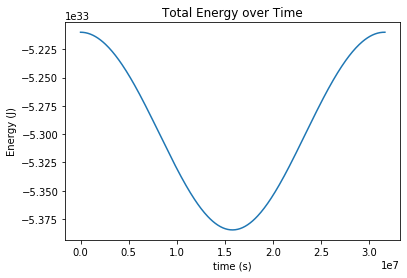

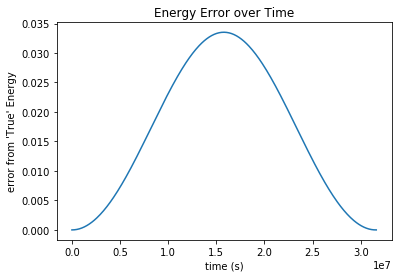

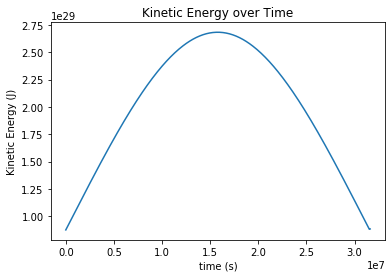

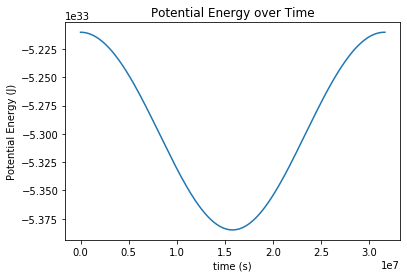

In [7]:
# we make four plots
# 1. Total mechanical energy of the system over time
# 2. Energy error over time. error is a decimal error where the initial energy is treated as the true energy of the system
# 3. Kinetic Energy of the system over time
# 4. Potential Energy of the system over time

plt.plot(times, energies)
plt.xlabel("time (s)")
plt.ylabel("Energy (J)")
plt.title("Total Energy over Time")
plt.show()

energy_frac_err = abs((energies - np.array([energies[0]] * len(energies)))/energies[0])

plt.plot(times, energy_frac_err)
plt.xlabel("time (s)")
plt.ylabel("error from 'True' Energy")
plt.title("Energy Error over Time")
plt.show()

plt.plot(times, kinetic)
plt.xlabel("time (s)")
plt.ylabel("Kinetic Energy (J)")
plt.title("Kinetic Energy over Time")
plt.show()

plt.plot(times, potential)
plt.xlabel("time (s)")
plt.ylabel("Potential Energy (J)")
plt.title("Potential Energy over Time")
plt.show()

Bibliography

Williams, D. R. (2019, October 21). Planetary Fact Sheet. NASA. https://nssdc.gsfc.nasa.gov/planetary/factsheet/.

Wikipedia. (2021, June 10). Leapfrog integration. https://en.wikipedia.org/wiki/Leapfrog_integration.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ed94618c-7db7-48f1-99aa-8d2a12e24eb8' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>